# 🏍️ LossZero: Motorcycle Night Ride SegFormer-B2 Optimized

이 노트북은 **SegFormer-B2** 모델을 사용하여 야간 오토바이 주행 이미지의 시멘틱 세그멘테이션을 수행합니다.

### 🛠️ 주요 시나리오
- **모델**: SegFormer-B2 (Transformer 기반)
- **백본**: MiT-B2
- **사전 학습**: Cityscapes (도로 환경 특화)
- **최적화**: AdamW + FP16 Mixed Precision
- **손실 함수**: Weighted CrossEntropy (중요 객체 가중치 부여)

In [48]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import SegformerForSemanticSegmentation, SegformerConfig
from torch.amp import autocast, GradScaler
from tqdm.auto import tqdm
import wandb
# wandb.login()

print(f"PyTorch version: {torch.__version__}")


PyTorch version: 2.6.0


## Colab 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def get_device():
    if torch.cuda.is_available():
        return "cuda"

    return "cpu"

def num_worker():
    if torch.cuda.is_available():
        return os.cpu_count()

    return 0

# ⚙️ 설정 (Configuration)
# DATA_DIR = "/content/drive/MyDrive/motor_model"
# DATA_DIR = "/home/jovyan/work/motorcycle/Dataset"
# DATA_DIR = "/home/jovyan/work/data/LossZero"
DATA_DIR = os.path.expanduser("~/Projects/LossZero/data/Motorcycle Night Ride Dataset")
print("Detected Local Environment")

JSON_PATH = os.path.join(DATA_DIR, "COCO_motorcycle (pixel).json")
IMG_DIR = os.path.join(DATA_DIR, "images")

CFG = {
    "project": "LossZero",
    "model_name": "nvidia/segformer-b2-finetuned-cityscapes-1024-1024",
    "img_size": (384, 672),
    "batch_size": 8,
    "lr": 1e-4,
    "epochs": 20,
    "device": get_device(),
    "num_worker": num_worker(),
    "train": True,
    "wndb": False,
}

if CFG["wndb"]:
    wandb.login()

print(f"Using device: {CFG['device']}")
print(f"Data directory: {DATA_DIR}")

Detected Local Environment
Using device: mps
Data directory: /Users/jamesyang/Projects/LossZero/data/Motorcycle Night Ride Dataset


In [ ]:
def create_mask_from_json(coco, img_id, img_info, id_to_idx):
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

    for ann in anns:
        cat_id = ann['category_id']
        if cat_id in id_to_idx:
            cls_idx = id_to_idx[cat_id]
            pixel_mask = coco.annToMask(ann)
            mask[pixel_mask == 1] = cls_idx

    return mask

def process_single_data(coco, img_id, img_dir, id_to_idx, transform=None):
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(img_dir, img_info['file_name'])

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = create_mask_from_json(coco, img_id, img_info, id_to_idx)

    if transform:
        augmented = transform(image=image, mask=mask)
        image, mask = augmented['image'], augmented['mask']

    return image, torch.as_tensor(mask).long()

train_transform = A.Compose([
    #  이미지 전체 구도 파악을 위해 Resize 적용 (Copy-Paste 효과 극대화)
    A.Resize(height=CFG['img_size'][0], width=CFG['img_size'][1], p=1.0),

    # --- 야간 전용 Augmentation 추가 ---
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.5), # 어두운 저조도 개선
    A.GaussNoise(std_range=(0.02, 0.05), p=0.3), # 야간 노이즈 대응

    # --- 기하학적 변형 (데이터 수 보충용) ---
    A.HorizontalFlip(p=0.5), # 좌우 반전
    # 0.0625는 머신러닝/딥러닝 커뮤니티에서 오랫동안 검증된 '사실상 표준(De Facto Standard)
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=25, p=0.5), # 이동/크기/회전

    # ImageNet 데이타셋의 평균값 나쁘지 않음. SegFormer가 ImageNet/Cityscapes로 배웠으니까
    # 모델이 새로운 사진을 받을 때: 입력_이미지 = (원본_이미지 - 평균) / 표준편차
    # 이렇게 계산해주면, 어떤 사진이 들어와도 "평균이 0이고 표준편차가 1인(Standard Normal Distribution)" 아주 예쁜 데이터로 변신
    # 전체 야간 데이터셋의 Mean/Std를 직접 계산한 값
    A.Normalize(mean=(0.281, 0.268, 0.346), std=(0.347, 0.290, 0.292)),
    ToTensorV2()
])

coco = COCO(JSON_PATH)
img_ids = list(coco.imgs.keys())
cat_ids = coco.getCatIds()
id_to_idx = {cat_id: i for i, cat_id in enumerate(cat_ids)}
print(f"Category Mapping: {id_to_idx}")

## Traing / Val 분리

In [39]:
import random
from sklearn.model_selection import train_test_split
class MotorcycleNightRideDataset(Dataset):
    def __init__(self, coco, img_ids, img_dir, id_to_idx, transform=None, use_copy_paste=False):
        self.coco = coco
        self.img_ids = img_ids
        self.img_dir = img_dir
        self.id_to_idx = id_to_idx
        self.transform = transform
        self.use_copy_paste = use_copy_paste  # Copy-Paste 활성화 여부 (Train만 True)

    def __len__(self):
        return len(self.img_ids)

    def load_image_mask(self, idx):
        """인덱스에 해당하는 이미지와 마스크를 로드하고 BGR->RGB 변환"""
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 마스크 생성 (기존 함수 활용)
        mask = create_mask_from_json(self.coco, img_id, img_info, self.id_to_idx)
        return image, mask

    def apply_copy_paste(self, image, mask):
        """
        Copy-Paste Augmentation:
        다른 이미지(Donor)에서 'Lane Mark(3)'나 'Moveable(2)' 같은 소수 클래스를 오려내어
        현재 이미지(Target)에 붙여넣습니다.
        """
        # 1. 기증자(Donor) 무작위 선택
        donor_idx = random.randint(0, len(self.img_ids) - 1)
        donor_img, donor_mask = self.load_image_mask(donor_idx)

        # 2. 오려낼 타겟 클래스 정의 (차선 집중 공략)
        # Lane Mark: 3
        target_indices = [3]

        # donor_mask에서 해당 클래스인 픽셀만 True (나머지 False)
        # np.isin을 사용하여 여러 클래스를 한 번에 처리
        paste_mask = np.isin(donor_mask, target_indices)

        # 3. 붙여넣기 (Paste)
        # 해당 영역에 내용물이 있을 경우에만 실행
        if np.any(paste_mask):
            # 이미지 덮어쓰기
            image[paste_mask] = donor_img[paste_mask]
            # 마스크 덮어쓰기 (정답지 수정)
            mask[paste_mask] = donor_mask[paste_mask]

        return image, mask

    def __getitem__(self, idx):
        # 1. 원본 데이터 로드
        image, mask = self.load_image_mask(idx)

        # 2. Copy-Paste 적용 (훈련 데이터셋이고, 100% 적용)
        if self.use_copy_paste and True:
            image, mask = self.apply_copy_paste(image, mask)

        # 3. Albumentations 변환 (Resize, ColorJitter, Normalization 등)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, torch.as_tensor(mask).long()

# --------------------------------------------------------------------------
# 1. 데이터 로드 및 ID 분할 (7:2:1)
coco = COCO(JSON_PATH)
all_ids = list(coco.imgs.keys())

# First split: 70% train, 30% temp
train_ids, temp_ids = train_test_split(all_ids, test_size=0.3, random_state=42)
# Second split: temp_ids into 2/3 for val (0.2 of total), 1/3 for test (0.1 of total)
val_ids, test_ids = train_test_split(temp_ids, test_size=1/3, random_state=42)

# 2. Transform 정의 (기존 정의 활용)
val_transform = A.Compose([
    A.Resize(CFG['img_size'][0], CFG['img_size'][1]),
    A.Normalize(mean=(0.281, 0.268, 0.346), std=(0.347, 0.290, 0.292)),
    ToTensorV2()
])
# Test transform is the same as validation transform
test_transform = val_transform

# 3. 데이터셋 인스턴스 생성 (★Train에만 Copy-Paste 활성화★)
train_dataset = MotorcycleNightRideDataset(
    coco, train_ids, IMG_DIR, id_to_idx,
    transform=train_transform,
    use_copy_paste=True  # Copy-Paste ON!
)
val_dataset = MotorcycleNightRideDataset(
    coco, val_ids, IMG_DIR, id_to_idx,
    transform=val_transform,
    use_copy_paste=False # Val에는 절대 쓰면 안 됨 (순수 평가)
)
test_dataset = MotorcycleNightRideDataset( # New test dataset
    coco, test_ids, IMG_DIR, id_to_idx,
    transform=test_transform,
    use_copy_paste=False # Test에는 절대 쓰면 안 됨 (순수 평가)
)

# 4. 데이터 로더 생성
train_loader = DataLoader(
    train_dataset,
    batch_size=CFG['batch_size'],
    shuffle=True,
    num_workers=CFG['num_worker'],
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=CFG['batch_size'],
    shuffle=False,
    num_workers=CFG['num_worker'],
    pin_memory=True
)
test_loader = DataLoader( # New test loader
    test_dataset,
    batch_size=CFG['batch_size'],
    shuffle=False,
    num_workers=CFG['num_worker'],
    pin_memory=True
)

# Define CFG_EVAL for later use
CFG_EVAL = {
    "num_classes": len(id_to_idx)
}

print(f"✅ Data Ready with Copy-Paste Augmentation!")
print(f"   Train={len(train_ids)} (CP Active), Val={len(val_ids)}, Test={len(test_ids)}")

loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
✅ Data Ready with Copy-Paste Augmentation!
   Train=140 (CP Active), Val=40, Test=20


### 📉 클래스별 분포 요약 (내림차순)

1. **Undrivable (주행 불가 영역)**: **42.9%** (압도적 1위)
   - 배경(하늘, 건물, 풀숲 등)이 이미지의 절반 가까이 차지합니다.
2. **Road (주행 가능 도로)**: **27.1%**
   - 도로 자체도 꽤 많은 영역을 차지합니다.
3. **My bike (내 오토바이)**: **15.8%**
   - 주행자 시점이라 내 오토바이가 항상 보이기 때문에 비율이 높습니다.
4. **Rider (탑승자)**: **8.1%**
   - 다른 오토바이 운전자나 내 신체가 포함된 것으로 보입니다.
5. **Moveable (이동 물체)**: **4.7%**
   - 다른 차량, 보행자 등 안전에 가장 중요한 장애물인데 비율이 매우 낮습니다.
6. **Lane Mark (차선)**: **1.4%**
   - 가장 심각한 불균형입니다. 도로 주행의 핵심인 차선이 고작 1% 남짓입니다.

In [40]:
id2label = {i: coco.loadCats(cat_id)[0]['name'] for cat_id, i in id_to_idx.items()}
label2id = {v: k for k, v in id2label.items()}

model = SegformerForSemanticSegmentation.from_pretrained(
    CFG['model_name'],
    num_labels=len(id_to_idx),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
).to(CFG['device'])

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CFG['lr'], # Learning Rate
    weight_decay=0.05 #가중치의 관성 제어, 옵티마이저에서 0.01이라는 값은 매 학습 단계(Step)마다 현재 가중치 값을 얼마나 깎을지를 결정하는 비율입니다.
)

# ⚖️ 클래스별 가중치 설정 (Class Weights)
weights = torch.tensor([
    3.0,   # Rider: 5.0 → 3.0 (중요하지만 과하지 않게)
    1.5,   # My bike: 2.0 → 1.5 (내 오토바이는 너무 잘 맞히니 조금 더 낮춤)
    6.0,   # Moveable: 10.0 → 6.0 (절반으로 줄여서 부담 완화)
    12.0,  # Lane Mark: 20.0 → 12 (여전히 제일 강력하지만, 20배는 너무 가혹했음)
    1.0,   # Road: 1.0 (기준점 유지)
    0.8    # Undrivable: 0.5 → 0.8 (배경을 너무 무시해서 도로 경계가 무너지는 것 방지)
], dtype=torch.float).to(CFG['device'])

criterion = nn.CrossEntropyLoss(weight=weights)

scaler = GradScaler('cuda') if CFG['device'] == 'cuda' else None

Loading weights:   0%|          | 0/380 [00:00<?, ?it/s]

SegformerForSemanticSegmentation LOAD REPORT from: nvidia/segformer-b2-finetuned-cityscapes-1024-1024
Key                           | Status   |                                                                                                    
------------------------------+----------+----------------------------------------------------------------------------------------------------
decode_head.classifier.weight | MISMATCH | Reinit due to size mismatch - ckpt: torch.Size([19, 768, 1, 1]) vs model:torch.Size([6, 768, 1, 1])
decode_head.classifier.bias   | MISMATCH | Reinit due to size mismatch - ckpt: torch.Size([19]) vs model:torch.Size([6])                      

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.


In [42]:
import torch
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix

# [1] 기본 IoU 계산 로직 (Category-specific)
def compute_category_iou(preds, targets, num_classes):
    preds_flat = preds.flatten().cpu().numpy()
    targets_flat = targets.flatten().cpu().numpy()
    valid_mask = (targets_flat >= 0) & (targets_flat < num_classes)
    preds_flat = preds_flat[valid_mask]
    targets_flat = targets_flat[valid_mask]
    cm = confusion_matrix(targets_flat, preds_flat, labels=range(num_classes))
    intersection = np.diag(cm)
    ground_truth_set = cm.sum(axis=1)
    predicted_set = cm.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    iou = intersection / (union + 1e-6)
    return iou

# [2] Boundary IoU 계산 로직
def get_boundary(mask, dilation_pixels=2):
    mask = mask.astype(np.uint8)
    kernel = np.ones((3, 3), np.uint8)
    eroded = cv2.erode(mask, kernel, iterations=dilation_pixels)
    boundary = mask - eroded
    return boundary

def compute_boundary_iou(preds, targets, num_classes, dilation_pixels=2):
    preds_np = preds.cpu().numpy()
    targets_np = targets.cpu().numpy()
    b_ious = []
    for c in range(num_classes):
        class_preds = (preds_np == c)
        class_targets = (targets_np == c)
        ious_per_batch = []
        for i in range(preds_np.shape[0]):
            gt_boundary = get_boundary(class_targets[i], dilation_pixels)
            pred_boundary = get_boundary(class_preds[i], dilation_pixels)
            intersection = ((gt_boundary > 0) & (pred_boundary > 0)).sum()
            union = ((gt_boundary > 0) | (pred_boundary > 0)).sum()
            if union == 0:
                ious_per_batch.append(1.0)
            else:
                ious_per_batch.append(intersection / union)
        if not ious_per_batch:
            b_ious.append(0.0)
        else:
            b_ious.append(np.mean(ious_per_batch))
    return np.array(b_ious)

# [3] 통합 평가 함수 (Metrics Calculation)
def evaluate_metrics(preds, targets, num_classes):
    """예측값과 정답을 받아 모든 지표(Category IoU, Boundary IoU)를 한 번에 계산"""
    cat_iou = compute_category_iou(preds, targets, num_classes)
    bound_iou = compute_boundary_iou(preds, targets, num_classes)
    return cat_iou, bound_iou

# [4] 상세 리포트 출력 함수 (Report Generation)
def print_evaluation_report(avg_cat_iou, avg_bound_iou, id2label=None):
    """계산된 평균 IoU 값들을 받아 보기 좋게 출력"""
    print("\n[Validation Report]")
    print("  Category-specific IoU:")
    for i, iou in enumerate(avg_cat_iou):
        label = id2label[i] if id2label else f"Class {i}"
        print(f"    - {label}: {iou:.4f}")

    print("\n  Boundary IoU (Details):")
    for i, iou in enumerate(avg_bound_iou):
        label = id2label[i] if id2label else f"Class {i}"
        print(f"    - {label}: {iou:.4f}")

    mIoU = np.nanmean(avg_cat_iou)
    mBoU = np.nanmean(avg_bound_iou)
    print(f"\n  --> mIoU: {mIoU:.4f} | mBoU: {mBoU:.4f}\n")
    return mIoU, mBoU


In [44]:
# [공통 로직] 데이터 전송, 추론, 확대, 손실 계산
def forward_step(model, images, masks, criterion, device):
    # 데이터를 GPU(CUDA) 또는 CPU 중 실제 연산이 일어날 장치로 보낸다
    # torch.Tensor 형태이며 contiguous()로 메모리를 정렬한다
    X = images.to(device).contiguous()
    y = masks.to(device).contiguous()

    # Forward Pass
    # logits: 우리가 찾는 클래스별 점수판 (필수!) -10.5나 15.2 같은 자유로운 숫자
    outputs = model(X).logits

    # 확대 (Interpolation)
    # 모델 결과물(outputs)은 연산 효율을 위해 96x96으로 축소되어 있음
    # 이를 정답지 y와 똑같은 크기(384x384)로 부드럽게 확대(Interpolate)
    # y.shape[-2:] -> (384, 384)
    upsampled_logits = nn.functional.interpolate(
        outputs, size=y.shape[-2:], mode="bilinear", align_corners=False
    )

    # 오차(Loss) 계산
    loss = criterion(upsampled_logits, y)

    return loss, upsampled_logits, y

# [학습 단계] 한 에폭 동안의 학습 집행
def train_one_epoch(model, loader, optimizer, criterion, device, scaler=None, epoch=0):
    model.train()
    train_loss_sum = 0
    pbar = tqdm(loader, desc=f"Epoch {epoch+1} [Train]")

    for images, masks in pbar:
        optimizer.zero_grad()

        # Mixed Precision 지원 (CUDA 전용)
        if device == 'cuda' and scaler:
            with torch.amp.autocast('cuda'):
                loss, _, _ = forward_step(model, images, masks, criterion, device)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # 역전파 및 가중치 업데이트
            loss, _, _ = forward_step(model, images, masks, criterion, device)
            loss.backward()
            optimizer.step()

        # 모델이 예측한 값과 정답 사이의 거리 기록
        train_loss_sum += loss.item()
        pbar.set_postfix(Loss=f"{loss.item():.4f}")

    return train_loss_sum / len(loader)

# [검증 단계] 모듈화된 평가 로직 적용
def validate(model, loader, criterion, device, num_classes=6, id2label=None):
    model.eval()
    val_loss_sum = 0

    # 지표 누적용 배열 (Total Accumulators)
    total_cat_ious = np.zeros(num_classes)
    total_bound_ious = np.zeros(num_classes)

    with torch.no_grad():
        for images, masks in loader:
            # 1. 공통 로직 실행 (Loss 계산)
            loss, logits, y = forward_step(model, images, masks, criterion, device)
            val_loss_sum += loss.item()

            # 2. 예측값 변환
            preds = torch.argmax(logits, dim=1)

            # 3. 통합 평가 모듈 호출
            cat_iou, bound_iou = evaluate_metrics(preds, y, num_classes)
            total_cat_ious += cat_iou
            total_bound_ious += bound_iou

    # 에폭 평균 계산
    avg_loss = val_loss_sum / len(loader)
    avg_cat_iou = total_cat_ious / len(loader)
    avg_bound_iou = total_bound_ious / len(loader)

    # 4. 상세 리포트 출력 모듈 호출
    mIoU, mBoU = print_evaluation_report(avg_cat_iou, avg_bound_iou, id2label)

    return avg_loss, mIoU, mBoU, avg_cat_iou, avg_bound_iou



In [ ]:
### 평가 항목
- **mIoU** (Mean Intersection over Union): only Validation
  - **Category-specific IoU** 
  - **Boundary IoU**
- CrossEntropyLoss : train loss/ validation loss   

In [45]:
# --- 🚀 메인 학습 루프 (Auto-Save 기능 탑재) ---
print("🚀 SegFormer-B2 Training Start with Dual Auto-Save Strategy...")

wandb.init(project=CFG['project'], config=CFG)

best_miou = 0.0
best_mbou = 0.0
best_miou_epoch = 0

save_dir = "./checkpoints"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(CFG['epochs']):
    # 1. 학습 실행
    avg_train_loss = train_one_epoch(model, train_loader, optimizer, criterion, CFG['device'], scaler, epoch)

    # 2. 검증 실행
    avg_val_loss, avg_val_miou, avg_val_mbou, mean_cat_ious, mean_bound_ious = validate(model, val_loader, criterion, CFG['device'], num_classes=6, id2label=id2label)


    # --- WandB 통합 로깅 (정밀 모니터링) ---
    log_dict = {
        'epoch': epoch,
        'Loss/Train': avg_train_loss,
        'Loss/Val': avg_val_loss,
        'Metrics/mIoU': avg_val_miou,
        'Metrics/mBoU': avg_val_mbou
    }

    # 클래스별 상세 IoU 기록
    for i, (cat_iou, b_iou) in enumerate(zip(mean_cat_ious, mean_bound_ious)):
        cls_name = id2label[i]
        log_dict[f'Class_IoU/{cls_name}'] = cat_iou
        log_dict[f'Class_Boundary_IoU/{cls_name}'] = b_iou

    wandb.log(log_dict)



    print(f"📝 Epoch [{epoch+1}/{CFG['epochs']}]")
    print(f"   Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"   ✨ Val mIoU: {avg_val_miou:.4f} | mBoU: {avg_val_mbou:.4f}")

    # --------------------------------------------------------------------------
    # 💾 3. 이중 자동 저장 (Dual Auto-Save)
    # --------------------------------------------------------------------------
    # [기준 1] mIoU 챔피언 (가장 똑똑한 모델)
    if avg_val_miou > best_miou:
        print(f"   🏆 New Best mIoU! ({best_miou:.4f} -> {avg_val_miou:.4f}) Saving...")
        best_miou = avg_val_miou
        best_miou_epoch = epoch + 1
        torch.save(model.state_dict(), os.path.join(save_dir, "segformer_best_miou.pth"))

    # [기준 2] mBoU 챔피언 (테두리 장인)
    if avg_val_mbou > best_mbou:
        print(f"   🎨 New Best mBoU! ({best_mbou:.4f} -> {avg_val_mbou:.4f}) Saving...")
        best_mbou = avg_val_mbou
        torch.save(model.state_dict(), os.path.join(save_dir, "segformer_best_mbou.pth"))

    # 0.5 수준: "기반은 닦았으나, 고득점 문제는 포기한 상태"
    # 0.1 수준: "실전에 투입해볼 만한 우등생"
    # 0.01 수준: "완벽, 혹은 너무 과한 공부(과적합)"
    print("-" * 50)

print(f"\n🎉 Training Complete!")
print(f"   👑 Overall Best mIoU: {best_miou:.4f} (at Epoch {best_miou_epoch})")
print(f"   🖌️ Overall Best mBoU: {best_mbou:.4f}")
# 마지막 상태도 저장
torch.save(model.state_dict(), os.path.join(save_dir, "segformer_last.pth"))

wandb.finish()



🚀 SegFormer-B2 Training Start with Dual Auto-Save Strategy...


Class_Boundary_IoU/Lane Mark,█▁▄
Class_Boundary_IoU/Moveable,▁▂█
Class_Boundary_IoU/My bike,█▆▁
Class_Boundary_IoU/Rider,▁▆█
Class_Boundary_IoU/Road,▁▅█
Class_Boundary_IoU/Undrivable,▁▄█
Class_IoU/Lane Mark,▁▃█
Class_IoU/Moveable,▁▄█
Class_IoU/My bike,▁█▇
Class_IoU/Rider,▁█▇
+7,...


Epoch 1 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.4099
    - My bike: 0.6591
    - Moveable: 0.2287
    - Lane Mark: 0.0708
    - Road: 0.3979
    - Undrivable: 0.8015

  Boundary IoU (Details):
    - Rider: 0.0227
    - My bike: 0.0604
    - Moveable: 0.0177
    - Lane Mark: 0.0200
    - Road: 0.0302
    - Undrivable: 0.0269

  --> mIoU: 0.4280 | mBoU: 0.0296

📝 Epoch [1/20]
   Train Loss: 1.4715 | Val Loss: 1.1675
   ✨ Val mIoU: 0.4280 | mBoU: 0.0296
   🏆 New Best mIoU! (0.0000 -> 0.4280) Saving...
   🎨 New Best mBoU! (0.0000 -> 0.0296) Saving...
--------------------------------------------------


Epoch 2 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.6617
    - My bike: 0.7624
    - Moveable: 0.4677
    - Lane Mark: 0.1021
    - Road: 0.6418
    - Undrivable: 0.8631

  Boundary IoU (Details):
    - Rider: 0.0484
    - My bike: 0.0738
    - Moveable: 0.0572
    - Lane Mark: 0.0215
    - Road: 0.0524
    - Undrivable: 0.0514

  --> mIoU: 0.5831 | mBoU: 0.0508

📝 Epoch [2/20]
   Train Loss: 1.0169 | Val Loss: 0.7683
   ✨ Val mIoU: 0.5831 | mBoU: 0.0508
   🏆 New Best mIoU! (0.4280 -> 0.5831) Saving...
   🎨 New Best mBoU! (0.0296 -> 0.0508) Saving...
--------------------------------------------------


Epoch 3 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.6896
    - My bike: 0.8147
    - Moveable: 0.5447
    - Lane Mark: 0.1164
    - Road: 0.6783
    - Undrivable: 0.8637

  Boundary IoU (Details):
    - Rider: 0.0363
    - My bike: 0.0814
    - Moveable: 0.0495
    - Lane Mark: 0.0214
    - Road: 0.0583
    - Undrivable: 0.0399

  --> mIoU: 0.6179 | mBoU: 0.0478

📝 Epoch [3/20]
   Train Loss: 0.7530 | Val Loss: 0.6100
   ✨ Val mIoU: 0.6179 | mBoU: 0.0478
   🏆 New Best mIoU! (0.5831 -> 0.6179) Saving...
--------------------------------------------------


Epoch 4 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.7179
    - My bike: 0.8494
    - Moveable: 0.5518
    - Lane Mark: 0.1604
    - Road: 0.7285
    - Undrivable: 0.8797

  Boundary IoU (Details):
    - Rider: 0.0549
    - My bike: 0.0918
    - Moveable: 0.0607
    - Lane Mark: 0.0383
    - Road: 0.0727
    - Undrivable: 0.0432

  --> mIoU: 0.6479 | mBoU: 0.0603

📝 Epoch [4/20]
   Train Loss: 0.5932 | Val Loss: 0.4885
   ✨ Val mIoU: 0.6479 | mBoU: 0.0603
   🏆 New Best mIoU! (0.6179 -> 0.6479) Saving...
   🎨 New Best mBoU! (0.0508 -> 0.0603) Saving...
--------------------------------------------------


Epoch 5 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.7316
    - My bike: 0.8761
    - Moveable: 0.6227
    - Lane Mark: 0.2110
    - Road: 0.7678
    - Undrivable: 0.9071

  Boundary IoU (Details):
    - Rider: 0.0629
    - My bike: 0.1272
    - Moveable: 0.0869
    - Lane Mark: 0.0523
    - Road: 0.0997
    - Undrivable: 0.0529

  --> mIoU: 0.6861 | mBoU: 0.0803

📝 Epoch [5/20]
   Train Loss: 0.5383 | Val Loss: 0.4362
   ✨ Val mIoU: 0.6861 | mBoU: 0.0803
   🏆 New Best mIoU! (0.6479 -> 0.6861) Saving...
   🎨 New Best mBoU! (0.0603 -> 0.0803) Saving...
--------------------------------------------------


Epoch 6 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.7783
    - My bike: 0.8796
    - Moveable: 0.4800
    - Lane Mark: 0.1880
    - Road: 0.7691
    - Undrivable: 0.8769

  Boundary IoU (Details):
    - Rider: 0.0785
    - My bike: 0.1348
    - Moveable: 0.0279
    - Lane Mark: 0.0468
    - Road: 0.1033
    - Undrivable: 0.0383

  --> mIoU: 0.6620 | mBoU: 0.0716

📝 Epoch [6/20]
   Train Loss: 0.4708 | Val Loss: 0.4041
   ✨ Val mIoU: 0.6620 | mBoU: 0.0716
--------------------------------------------------


Epoch 7 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.7471
    - My bike: 0.8851
    - Moveable: 0.6038
    - Lane Mark: 0.2280
    - Road: 0.7844
    - Undrivable: 0.9168

  Boundary IoU (Details):
    - Rider: 0.0730
    - My bike: 0.1442
    - Moveable: 0.0850
    - Lane Mark: 0.0611
    - Road: 0.1144
    - Undrivable: 0.0609

  --> mIoU: 0.6942 | mBoU: 0.0898

📝 Epoch [7/20]
   Train Loss: 0.4451 | Val Loss: 0.3922
   ✨ Val mIoU: 0.6942 | mBoU: 0.0898
   🏆 New Best mIoU! (0.6861 -> 0.6942) Saving...
   🎨 New Best mBoU! (0.0803 -> 0.0898) Saving...
--------------------------------------------------


Epoch 8 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.7934
    - My bike: 0.8884
    - Moveable: 0.5876
    - Lane Mark: 0.2192
    - Road: 0.7943
    - Undrivable: 0.9239

  Boundary IoU (Details):
    - Rider: 0.0857
    - My bike: 0.1693
    - Moveable: 0.0487
    - Lane Mark: 0.0572
    - Road: 0.1316
    - Undrivable: 0.0602

  --> mIoU: 0.7011 | mBoU: 0.0921

📝 Epoch [8/20]
   Train Loss: 0.4265 | Val Loss: 0.3573
   ✨ Val mIoU: 0.7011 | mBoU: 0.0921
   🏆 New Best mIoU! (0.6942 -> 0.7011) Saving...
   🎨 New Best mBoU! (0.0898 -> 0.0921) Saving...
--------------------------------------------------


Epoch 9 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.7733
    - My bike: 0.8969
    - Moveable: 0.6646
    - Lane Mark: 0.2193
    - Road: 0.8023
    - Undrivable: 0.9208

  Boundary IoU (Details):
    - Rider: 0.1036
    - My bike: 0.1629
    - Moveable: 0.0850
    - Lane Mark: 0.0589
    - Road: 0.1334
    - Undrivable: 0.0700

  --> mIoU: 0.7129 | mBoU: 0.1023

📝 Epoch [9/20]
   Train Loss: 0.3869 | Val Loss: 0.3430
   ✨ Val mIoU: 0.7129 | mBoU: 0.1023
   🏆 New Best mIoU! (0.7011 -> 0.7129) Saving...
   🎨 New Best mBoU! (0.0921 -> 0.1023) Saving...
--------------------------------------------------


Epoch 10 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8041
    - My bike: 0.8898
    - Moveable: 0.6549
    - Lane Mark: 0.2335
    - Road: 0.7901
    - Undrivable: 0.9171

  Boundary IoU (Details):
    - Rider: 0.0980
    - My bike: 0.1482
    - Moveable: 0.0588
    - Lane Mark: 0.0754
    - Road: 0.1343
    - Undrivable: 0.0723

  --> mIoU: 0.7149 | mBoU: 0.0979

📝 Epoch [10/20]
   Train Loss: 0.3867 | Val Loss: 0.3318
   ✨ Val mIoU: 0.7149 | mBoU: 0.0979
   🏆 New Best mIoU! (0.7129 -> 0.7149) Saving...
--------------------------------------------------


Epoch 11 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8212
    - My bike: 0.9038
    - Moveable: 0.6602
    - Lane Mark: 0.2144
    - Road: 0.7970
    - Undrivable: 0.9301

  Boundary IoU (Details):
    - Rider: 0.0972
    - My bike: 0.1869
    - Moveable: 0.0500
    - Lane Mark: 0.0571
    - Road: 0.1404
    - Undrivable: 0.0719

  --> mIoU: 0.7211 | mBoU: 0.1006

📝 Epoch [11/20]
   Train Loss: 0.3630 | Val Loss: 0.3083
   ✨ Val mIoU: 0.7211 | mBoU: 0.1006
   🏆 New Best mIoU! (0.7149 -> 0.7211) Saving...
--------------------------------------------------


Epoch 12 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8254
    - My bike: 0.9072
    - Moveable: 0.6616
    - Lane Mark: 0.2256
    - Road: 0.8071
    - Undrivable: 0.9316

  Boundary IoU (Details):
    - Rider: 0.1412
    - My bike: 0.2095
    - Moveable: 0.0676
    - Lane Mark: 0.0626
    - Road: 0.1631
    - Undrivable: 0.0835

  --> mIoU: 0.7264 | mBoU: 0.1213

📝 Epoch [12/20]
   Train Loss: 0.3275 | Val Loss: 0.3138
   ✨ Val mIoU: 0.7264 | mBoU: 0.1213
   🏆 New Best mIoU! (0.7211 -> 0.7264) Saving...
   🎨 New Best mBoU! (0.1023 -> 0.1213) Saving...
--------------------------------------------------


Epoch 13 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8060
    - My bike: 0.9128
    - Moveable: 0.5931
    - Lane Mark: 0.2784
    - Road: 0.8256
    - Undrivable: 0.9328

  Boundary IoU (Details):
    - Rider: 0.1252
    - My bike: 0.2066
    - Moveable: 0.1109
    - Lane Mark: 0.0964
    - Road: 0.1805
    - Undrivable: 0.0870

  --> mIoU: 0.7248 | mBoU: 0.1344

📝 Epoch [13/20]
   Train Loss: 0.3115 | Val Loss: 0.3374
   ✨ Val mIoU: 0.7248 | mBoU: 0.1344
   🎨 New Best mBoU! (0.1213 -> 0.1344) Saving...
--------------------------------------------------


Epoch 14 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.7927
    - My bike: 0.9049
    - Moveable: 0.6592
    - Lane Mark: 0.2497
    - Road: 0.8090
    - Undrivable: 0.9181

  Boundary IoU (Details):
    - Rider: 0.1141
    - My bike: 0.1831
    - Moveable: 0.0533
    - Lane Mark: 0.0747
    - Road: 0.1563
    - Undrivable: 0.0627

  --> mIoU: 0.7223 | mBoU: 0.1073

📝 Epoch [14/20]
   Train Loss: 0.3193 | Val Loss: 0.3017
   ✨ Val mIoU: 0.7223 | mBoU: 0.1073
--------------------------------------------------


Epoch 15 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8209
    - My bike: 0.9112
    - Moveable: 0.6918
    - Lane Mark: 0.2428
    - Road: 0.8228
    - Undrivable: 0.9351

  Boundary IoU (Details):
    - Rider: 0.1390
    - My bike: 0.2232
    - Moveable: 0.0982
    - Lane Mark: 0.0714
    - Road: 0.1779
    - Undrivable: 0.0930

  --> mIoU: 0.7374 | mBoU: 0.1338

📝 Epoch [15/20]
   Train Loss: 0.2941 | Val Loss: 0.2991
   ✨ Val mIoU: 0.7374 | mBoU: 0.1338
   🏆 New Best mIoU! (0.7264 -> 0.7374) Saving...
--------------------------------------------------


Epoch 16 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8039
    - My bike: 0.9110
    - Moveable: 0.7052
    - Lane Mark: 0.3047
    - Road: 0.8408
    - Undrivable: 0.9343

  Boundary IoU (Details):
    - Rider: 0.1615
    - My bike: 0.2066
    - Moveable: 0.1281
    - Lane Mark: 0.1188
    - Road: 0.2061
    - Undrivable: 0.0999

  --> mIoU: 0.7500 | mBoU: 0.1535

📝 Epoch [16/20]
   Train Loss: 0.3151 | Val Loss: 0.2975
   ✨ Val mIoU: 0.7500 | mBoU: 0.1535
   🏆 New Best mIoU! (0.7374 -> 0.7500) Saving...
   🎨 New Best mBoU! (0.1344 -> 0.1535) Saving...
--------------------------------------------------


Epoch 17 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8210
    - My bike: 0.9126
    - Moveable: 0.6634
    - Lane Mark: 0.2484
    - Road: 0.8186
    - Undrivable: 0.9289

  Boundary IoU (Details):
    - Rider: 0.1180
    - My bike: 0.2192
    - Moveable: 0.0640
    - Lane Mark: 0.0747
    - Road: 0.1718
    - Undrivable: 0.0714

  --> mIoU: 0.7322 | mBoU: 0.1199

📝 Epoch [17/20]
   Train Loss: 0.2837 | Val Loss: 0.2825
   ✨ Val mIoU: 0.7322 | mBoU: 0.1199
--------------------------------------------------


Epoch 18 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8374
    - My bike: 0.9189
    - Moveable: 0.6139
    - Lane Mark: 0.2712
    - Road: 0.8255
    - Undrivable: 0.9390

  Boundary IoU (Details):
    - Rider: 0.1326
    - My bike: 0.2371
    - Moveable: 0.1209
    - Lane Mark: 0.0894
    - Road: 0.1926
    - Undrivable: 0.0926

  --> mIoU: 0.7343 | mBoU: 0.1442

📝 Epoch [18/20]
   Train Loss: 0.2771 | Val Loss: 0.3102
   ✨ Val mIoU: 0.7343 | mBoU: 0.1442
--------------------------------------------------


Epoch 19 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8404
    - My bike: 0.9186
    - Moveable: 0.7036
    - Lane Mark: 0.2874
    - Road: 0.8366
    - Undrivable: 0.9403

  Boundary IoU (Details):
    - Rider: 0.1509
    - My bike: 0.2348
    - Moveable: 0.0893
    - Lane Mark: 0.1077
    - Road: 0.2065
    - Undrivable: 0.0927

  --> mIoU: 0.7545 | mBoU: 0.1470

📝 Epoch [19/20]
   Train Loss: 0.2570 | Val Loss: 0.2688
   ✨ Val mIoU: 0.7545 | mBoU: 0.1470
   🏆 New Best mIoU! (0.7500 -> 0.7545) Saving...
--------------------------------------------------


Epoch 20 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8032
    - My bike: 0.9216
    - Moveable: 0.5958
    - Lane Mark: 0.3256
    - Road: 0.8325
    - Undrivable: 0.9373

  Boundary IoU (Details):
    - Rider: 0.1218
    - My bike: 0.2632
    - Moveable: 0.1040
    - Lane Mark: 0.1299
    - Road: 0.2155
    - Undrivable: 0.1001

  --> mIoU: 0.7360 | mBoU: 0.1557

📝 Epoch [20/20]
   Train Loss: 0.2692 | Val Loss: 0.3225
   ✨ Val mIoU: 0.7360 | mBoU: 0.1557
   🎨 New Best mBoU! (0.1535 -> 0.1557) Saving...
--------------------------------------------------

🎉 Training Complete!
   👑 Overall Best mIoU: 0.7545 (at Epoch 19)
   🖌️ Overall Best mBoU: 0.1557


Class_Boundary_IoU/Lane Mark,▁▁▁▂▃▃▄▃▃▅▃▄▆▄▄▇▄▅▇█
Class_Boundary_IoU/Moveable,▁▄▃▄▅▂▅▃▅▄▃▄▇▃▆█▄█▆▆
Class_Boundary_IoU/My bike,▁▁▂▂▃▄▄▅▅▄▅▆▆▅▇▆▆▇▇█
Class_Boundary_IoU/Rider,▁▂▂▃▃▄▄▄▅▅▅▇▆▆▇█▆▇▇▆
Class_Boundary_IoU/Road,▁▂▂▃▄▄▄▅▅▅▅▆▇▆▇█▆▇██
Class_Boundary_IoU/Undrivable,▁▃▂▃▃▂▄▄▅▅▅▆▇▄▇█▅▇▇█
Class_IoU/Lane Mark,▁▂▂▃▅▄▅▅▅▅▅▅▇▆▆▇▆▇▇█
Class_IoU/Moveable,▁▅▆▆▇▅▇▆▇▇▇▇▆▇██▇▇█▆
Class_IoU/My bike,▁▄▅▆▇▇▇▇▇▇██████████
Class_IoU/Rider,▁▅▆▆▆▇▆▇▇▇██▇▇█▇███▇
+7,...


## 🚦 Grad-CAM: 모델 의사결정 근거 시각화

**1. 분석 대상:** `segformer_best_miou.pth` (최고 성능 가중치 로드)
**2. 선정 이유:** **mIoU**가 가장 높은 모델의 '판단 논리'를 정성적으로 검증하기 위함

**3. 기술적 요점:**
* **Target:** Encoder Stage 4 MLP (최종 특징 추출 단계)
* **Method:** Transformer 시퀀스 데이터를 2D 피처맵($12 \times 21$)으로 복원 시각화
* **Layout:** 원본 대비 클래스별 히트맵 1행 2열 배치 (무작위 샘플링)



**💡 요약:** "가장 똑똑한 모델(Best mIoU)이 밤길 객체를 정확한 근거로 식별하는지 시각적으로 증명합니다."

✅ 학습 완료된 베스트 모델 로드 성공: ./checkpoints/segformer_best_miou.pth
📸 분석 시작: Best mIoU 모델을 사용해 39번 이미지를 분석합니다.


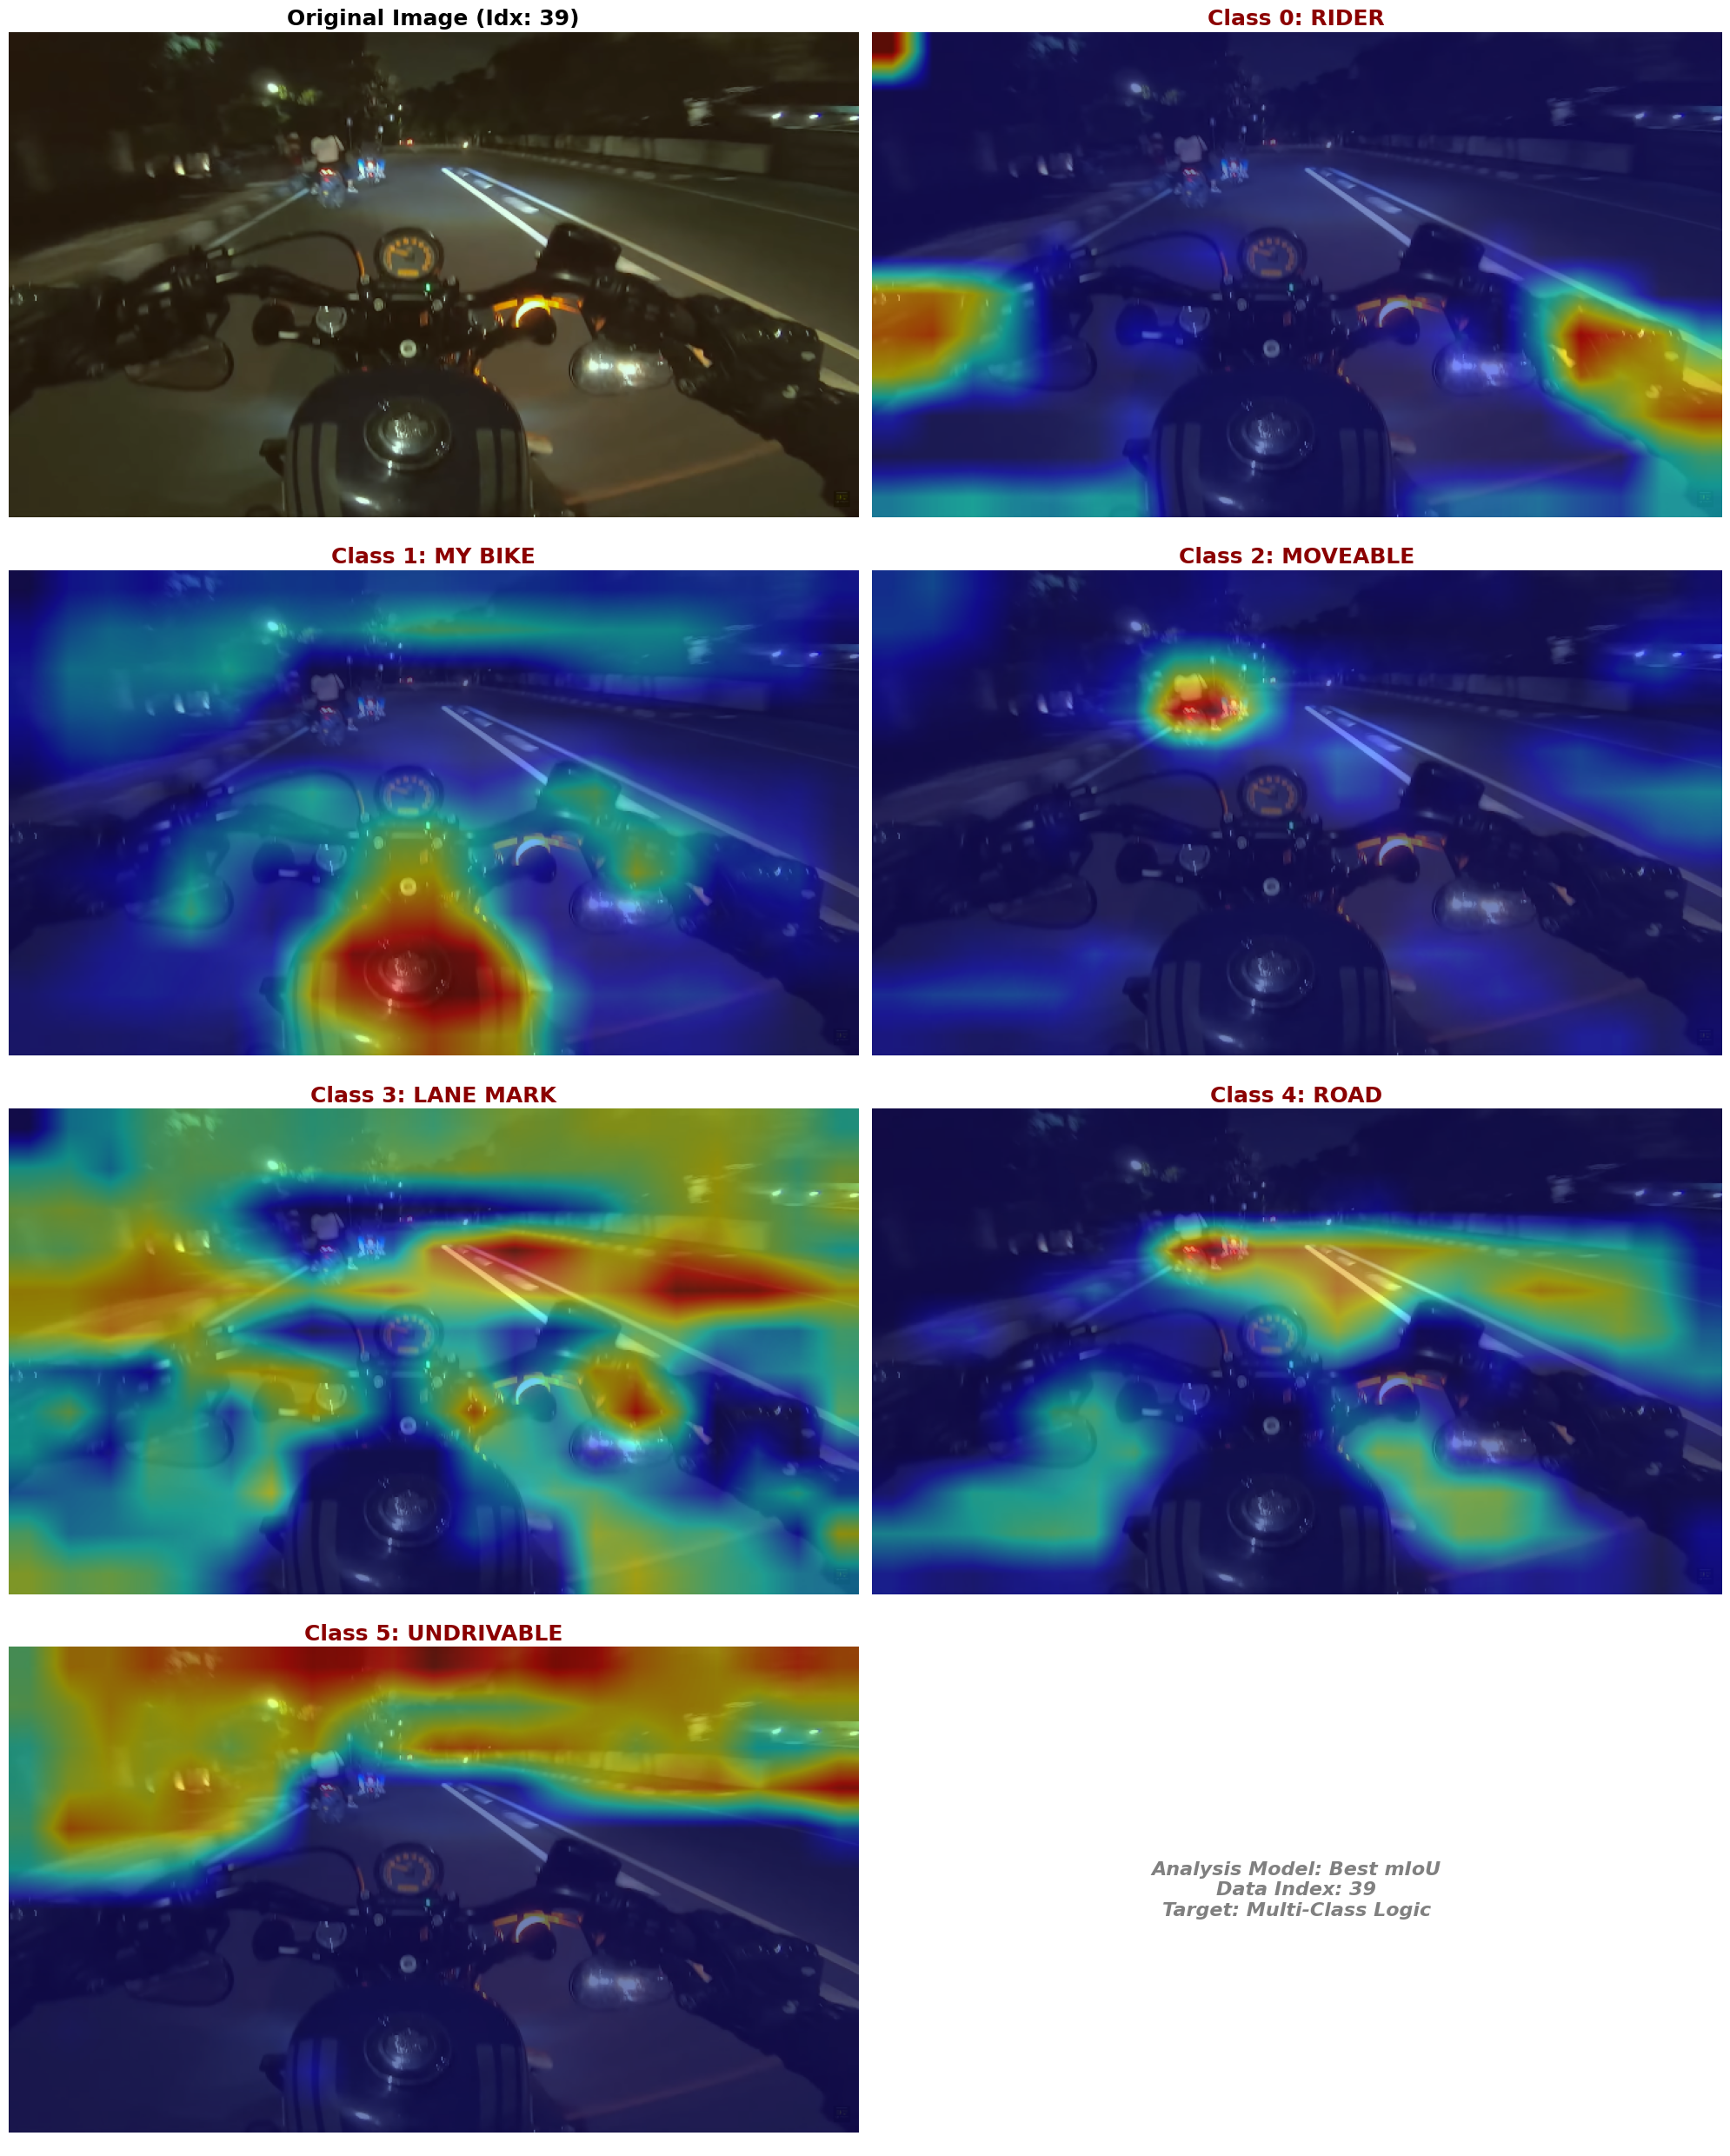

✅ 모든 시각화가 완료되었습니다. (사용한 모델: ./checkpoints/segformer_best_miou.pth)


In [61]:
# !pip install grad-cam
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget

# -------------------------------------------------------------------------
# [ 핵심 ] 1. 최고의 성능을 낸 mIoU 모델(.pth) 불러오기
# -------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = "./checkpoints/segformer_best_miou.pth"

# 모델에 학습된 가중치 주입 (이 과정이 있어야 '지능'이 탑재됩니다)
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print(f"✅ 학습 완료된 베스트 모델 로드 성공: {checkpoint_path}")
else:
    print(f"⚠️ 경고: {checkpoint_path} 파일을 찾을 수 없습니다. 현재 메모리의 모델을 사용합니다.")

# 2. Grad-CAM용 Wrapper 및 Reshape 함수 설정
class SegformerModelWrapper(nn.Module):
    def __init__(self, model):
        super(SegformerModelWrapper, self).__init__()
        self.model = model
    def forward(self, x):
        return self.model(x).logits

def segformer_reshape_transform(tensor, height=12, width=21):
    result = tensor.reshape(tensor.size(0), height, width, -1)
    result = result.transpose(2, 3).transpose(1, 2)
    return result

wrapped_model = SegformerModelWrapper(model).to(device)
wrapped_model.eval()

# 3. Grad-CAM 객체 생성 (Stage 4 MLP 타겟)
target_layers = [wrapped_model.model.segformer.encoder.block[3][1].mlp]
cam = GradCAM(model=wrapped_model, 
              target_layers=target_layers, 
              reshape_transform=segformer_reshape_transform)

# 4. 무작위 사진 선택 (매번 실행 시마다 새로운 데이터)
random_idx = random.randint(0, len(val_dataset) - 1)
image, mask = val_dataset[random_idx]
input_tensor = image.unsqueeze(0).to(device)
input_tensor.requires_grad = True

# 5. 배경 이미지 준비
rgb_img = input_tensor[0].detach().cpu().permute(1, 2, 0).numpy()
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

# ==========================================
# 6. 4행 2열(총 8칸) 그리드 설정 및 출력
# ==========================================
num_classes = 6
fig, axes = plt.subplots(4, 2, figsize=(20, 25))
axes = axes.flatten()

print(f"📸 분석 시작: Best mIoU 모델을 사용해 {random_idx}번 이미지를 분석합니다.")

# [첫 번째 칸] 원본 이미지
axes[0].imshow(rgb_img)
axes[0].set_title(f"Original Image (Idx: {random_idx})", fontsize=18, fontweight='bold')
axes[0].axis('off')

# [두 번째~일곱 번째 칸] 각 클래스별 Grad-CAM 계산 및 합성
output_h, output_w = input_tensor.shape[2] // 4, input_tensor.shape[3] // 4
mask_float = np.ones((output_h, output_w), dtype=np.float32)

for i in range(num_classes):
    class_name = id2label[i]
    targets = [SemanticSegmentationTarget(category=i, mask=mask_float)]
    
    # Grad-CAM 생성
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    
    # 그리드 배치
    axes[i+1].imshow(visualization)
    axes[i+1].set_title(f"Class {i}: {class_name.upper()}", fontsize=18, color='darkred', fontweight='bold')
    axes[i+1].axis('off')

# [여덟 번째 칸] 정보 표시
axes[7].axis('off')
axes[7].text(0.5, 0.5, f"Analysis Model: Best mIoU\nData Index: {random_idx}\nTarget: Multi-Class Logic", 
             ha='center', va='center', fontsize=16, color='gray', style='italic', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"✅ 모든 시각화가 완료되었습니다. (사용한 모델: {checkpoint_path})")

## 🚀 Enhanced Evaluation & Profiling

### 🛠️ 주요 평가 항목
- **실시간성 및 하드웨어 지표**
  - **Model Parameters**
  - **MACs** Multiply-Accumulate Operations
    - y = wx + b 에서 wx + b를 1MAC 이라고 한다.
  - **GFLOPs** Giga Floating Point Operations
    -  모델을 한 번 실행(Forward Pass)할 때 필요한 총 부동 소수점 연산량
    - 보통 1MAC = 2FLOPs
  - **Average Inference Latency**
  - **Frames Per Second (FPS)**
- **Safety-critical Metrics**

In [70]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


class SafetyEvalMetrics:
    def __init__(self, num_classes, class_names):
        self.num_classes = num_classes
        self.class_names = class_names
        self.confusion_matrix = np.zeros((num_classes, num_classes))

    def update(self, preds, gts):
        """
        한 배치(Batch) 또는 한 프레임의 결과를 누적합니다.
        preds, gts: [Batch, H, W] 형태의 Tensor 또는 Numpy
        """
        preds = preds.flatten()
        gts = gts.flatten()

        # 유효하지 않은 타겟 값 제외 (예: 패딩 또는 ignore_index가 포함된 경우)
        valid_mask = (gts >= 0) & (gts < self.num_classes)
        preds = preds[valid_mask]
        gts = gts[valid_mask]

        # sklearn의 confusion_matrix를 사용하여 매트릭스 업데이트
        # labels 인자를 명시적으로 제공하여 모든 클래스가 포함되도록 보장
        new_cm = confusion_matrix(gts, preds, labels=range(self.num_classes))
        self.confusion_matrix += new_cm

    def plot_confusion_matrix(self, normalize=True):
        """
        혼동 행렬 시각화
        """
        cm = self.confusion_matrix
        if normalize:
            # 행(Actual) 기준 정규화: 해당 클래스가 실제 무엇으로 예측되었는지 비율 확인
            # 0으로 나누는 오류 방지를 위해 1e-9 추가
            cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)

        plt.figure(figsize=(8, 5))
        sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d",
                    cmap="Blues", xticklabels=self.class_names, yticklabels=self.class_names)

        plt.title('Road Scene Segmentation: Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('Ground Truth Label')
        plt.show()

    def analyze_safety_risks(self):
        """
        치명적 오분류(Safety-Critical) 집중 분석
        """
        cm_norm = self.confusion_matrix.astype('float') / (self.confusion_matrix.sum(axis=1)[:, np.newaxis] + 1e-9)

        print("\n=== [Safety-Critical Analysis] ===")

        try:
            rider_idx = self.class_names.index('Rider')
            mybike_idx = self.class_names.index('My bike')
            moveable_idx = self.class_names.index('Moveable')
            lanemark_idx = self.class_names.index('Lane Mark')
            road_idx = self.class_names.index('Road')
            undrivable_idx = self.class_names.index('Undrivable')

            print("--- 고위험 ---")
            # Case 1: Undrivable (주행 불가 영역)이 Road (주행 가능 도로)로 오분류된 경우
            # 실제 장애물이나 위험 지역을 도로로 인식하여 충돌 위험이 매우 높음.
            undrivable_as_road = cm_norm[undrivable_idx, road_idx]
            print(f"1. 즉각적인 충돌 위험 - 'Undrivable' 영역의 {undrivable_as_road:.2%}가 'Road'로 오분류 됨.")

            # Case 2: Moveable (이동 물체)이 Undrivable (주행 불가 영역)로 오분류된 경우
            # 다른 차량이나 보행자 등 중요한 이동 장애물을 감지하지 못하고 통행 불가 영역으로 표시했음을 의미.
            missed_moveable_as_undrivable = cm_norm[moveable_idx, undrivable_idx]
            print(f"2. 이동 물체 충돌 위험 - 'Moveable' 객체의 {missed_moveable_as_undrivable:.2%}가 'Undrivable'로 오분류 됨.")

            # Case 3: Moveable (이동 물체)이 Road (주행 가능 도로)로 오분류된 경우
            # 다른 차량이나 보행자 등 중요한 이동 장애물을 감지하지 못하고 안전한 주행 가능 영역으로 표시했음을 의미.
            missed_moveable_as_road = cm_norm[moveable_idx, road_idx]
            print(f"3. 이동 물체 충돌 위험 - 'Moveable' 객체의 {missed_moveable_as_road:.2%}가 'Road'로 오분류 됨.")

            # Case 4: Rider (탑승자)가 Undrivable (주행 불가 영역)로 오분류된 경우
            # 자율주행 시스템이 탑승자(자신)를 장애물로 인식하여 불필요한 회피 기동이나 정지를 유발할 수 있음.
            rider_as_undrivable = cm_norm[rider_idx, undrivable_idx]
            print(f"4. 시스템 오작동 유발 - 'Rider' 객체의 {rider_as_undrivable:.2%}가 'Undrivable'로 오분류 됨.")

            print("\n--- 중위험 ---")
            # Case 5: Road (주행 가능 도로)가 Undrivable (주행 불가 영역)로 오분류된 경우
            # 주행 가능한 도로를 통행 불가능하다고 간주하여 잘못된 경로 계획이나 불필요한 제동으로 이어질 수 있음.
            road_to_undrivable = cm_norm[road_idx, undrivable_idx]
            print(f"5. 경로 계획 오류 - 'Road' 영역의 {road_to_undrivable:.2%}가 'Undrivable'로 오분류 됨.")

            # Case 6: Lane Mark (차선)가 Road (주행 가능 도로)로 오분류된 경우
            # 차선이 도로의 일부로 인식되어 차선 유지 보조 시스템의 오작동을 유발하거나 차선 이탈을 방지하지 못할 수 있음.
            lanemark_as_road = cm_norm[lanemark_idx, road_idx]
            print(f"6. 차선 유지 보조 오류 - 'Lane Mark' 영역의 {lanemark_as_road:.2%}가 'Road'로 오분류 됨.")

            print("\n--- 낮은-중간 위험 ---")
            # Case 7: Rider (탑승자)가 My bike (내 오토바이)로 오분류된 경우
            # 시스템의 자기 인식에 혼란을 주지만, 직접적인 충돌 위험은 낮음. 정밀한 자율 주행에는 영향.
            rider_as_mybike = cm_norm[rider_idx, mybike_idx]
            print(f"7. 자기 인식 오류 - 'Rider' 객체의 {rider_as_mybike:.2%}가 'My bike'로 오분류 됨.")

        except ValueError as e:
            print(f"오류: 데이터셋의 클래스 이름을 확인하세요: {e}")


In [72]:
import time
from thop import profile

def profile_model(model, img_size, device):
    print(f"🚀 Starting Model Profiling for: {model.__class__.__name__}...")

    # 모델을 평가 모드로 설정
    model.eval()

    # 2. 모델을 위한 더미 입력 텐서 생성
    dummy_input = torch.randn(1, 3, img_size[0], img_size[1]).to(device)

    # 3. 더미 입력을 사용하여 모델의 MACs 및 매개변수(params)를 계산하기 위해 thop.profile 사용. verbose=False로 설정.
    macs, params = profile(model, inputs=(dummy_input,), verbose=False)

    # 4. 계산된 MACs를 1e9로 나누어 GFLOPs로 변환.
    gflops = (macs * 2) / 1e9

    print(f"  Model Parameters (M): {params / 1e6:.2f}")
    print(f"  MACs (G): {macs / 1e9:.2f}")
    print(f"  GFLOPs: {gflops:.2f}")

    # 5. 지연 시간 및 FPS 측정을 위한 변수 초기화.
    num_warmup_runs = 10
    num_inference_runs = 100
    total_latency = 0.0

    # 6. 워밍업 실행 수행
    # print(f"  Performing {num_warmup_runs} warm-up runs...")
    with torch.no_grad():
        for _ in range(num_warmup_runs):
            _ = model(dummy_input)

    # 7. 추론 지연 시간 측정
    # print(f"  Measuring latency over {num_inference_runs} inference runs...")
    with torch.no_grad():
        for _ in range(num_inference_runs):
            start_time = time.perf_counter()
            _ = model(dummy_input)
            end_time = time.perf_counter()
            total_latency += (end_time - start_time)

    # 8. 평균 지연 시간(ms) 계산
    average_latency_ms = (total_latency / num_inference_runs) * 1000

    # 9. FPS 계산
    fps = 1000 / average_latency_ms

    print(f"  Average Inference Latency: {average_latency_ms:.2f} ms")
    print(f"  Frames Per Second (FPS): {fps:.2f}")

def run_safety_evaluation(model, model_name, loader, device, num_classes, id2label):
    print(f"🚀 Starting Safety Evaluation for: {model_name}...")
    
    # 1. 클래스 이름 준비 (ID 순서대로 정렬)
    class_names = [name for i, name in sorted(id2label.items())]
    
    # 2. 전용 평가기 인스턴스 생성
    evaluator = SafetyEvalMetrics(num_classes=num_classes, class_names=class_names)
    
    # 3. 모델을 평가 모드로 설정
    model.eval()
    
    # 4. 루프를 돌며 예측 및 행렬 업데이트
    with torch.no_grad():
        for images, masks in tqdm(loader, desc=f"Evaluating {model_name}"):
            X = images.to(device).contiguous()
            y = masks.to(device).contiguous()

            # 모델 추론
            outputs = model(X).logits
            
            # 마스크 크기에 맞게 업샘플링
            upsampled_logits = nn.functional.interpolate(
                outputs,
                size=y.shape[-2:],
                mode="bilinear",
                align_corners=False
            )

            preds = upsampled_logits.argmax(dim=1)
            
            # 결과 누적
            evaluator.update(preds.cpu().numpy(), y.cpu().numpy())

    # 5. 결과 시각화 및 리스크 분석 출력
    print(f"\n📊 Confusion Matrix: {model_name}")
    evaluator.plot_confusion_matrix(normalize=True)
    
    print(f"\n⚠️ Safety Risk Analysis: {model_name}")
    evaluator.analyze_safety_risks()


Loading weights:   0%|          | 0/380 [00:00<?, ?it/s]

SegformerForSemanticSegmentation LOAD REPORT from: nvidia/segformer-b2-finetuned-cityscapes-1024-1024
Key                           | Status   |                                                                                                    
------------------------------+----------+----------------------------------------------------------------------------------------------------
decode_head.classifier.weight | MISMATCH | Reinit due to size mismatch - ckpt: torch.Size([19, 768, 1, 1]) vs model:torch.Size([6, 768, 1, 1])
decode_head.classifier.bias   | MISMATCH | Reinit due to size mismatch - ckpt: torch.Size([19]) vs model:torch.Size([6])                      

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.


Loading weights:   0%|          | 0/380 [00:00<?, ?it/s]

SegformerForSemanticSegmentation LOAD REPORT from: nvidia/segformer-b2-finetuned-cityscapes-1024-1024
Key                           | Status   |                                                                                                    
------------------------------+----------+----------------------------------------------------------------------------------------------------
decode_head.classifier.weight | MISMATCH | Reinit due to size mismatch - ckpt: torch.Size([19, 768, 1, 1]) vs model:torch.Size([6, 768, 1, 1])
decode_head.classifier.bias   | MISMATCH | Reinit due to size mismatch - ckpt: torch.Size([19]) vs model:torch.Size([6])                      

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.


🚀 Starting Model Profiling for: SegformerForSemanticSegmentation...
  Model Parameters (M): 27.35
  MACs (G): 55.88
  GFLOPs: 111.75
  Average Inference Latency: 37.99 ms
  Frames Per Second (FPS): 26.32


🚀 Starting Model Profiling for: SegformerForSemanticSegmentation...
  Model Parameters (M): 27.35
  MACs (G): 55.88
  GFLOPs: 111.75
  Average Inference Latency: 37.63 ms
  Frames Per Second (FPS): 26.58
🚀 Starting Safety Evaluation for: Best mIoU Model...


Evaluating Best mIoU Model:   0%|          | 0/3 [00:00<?, ?it/s]


📊 Confusion Matrix: Best mIoU Model


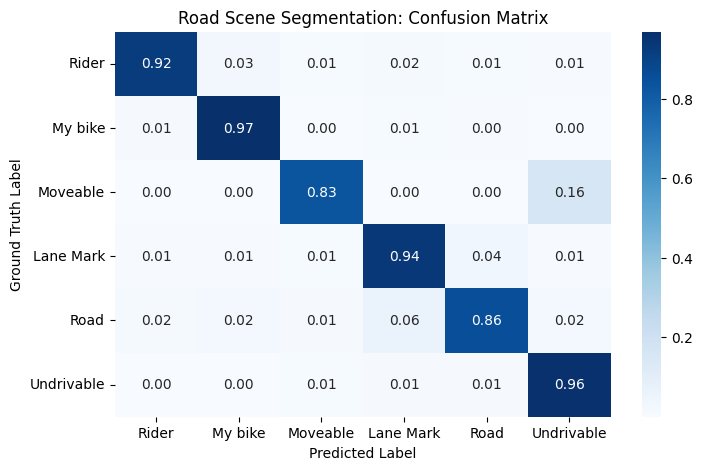


⚠️ Safety Risk Analysis: Best mIoU Model

=== [Safety-Critical Analysis] ===
--- 고위험 ---
1. 즉각적인 충돌 위험 - 'Undrivable' 영역의 1.36%가 'Road'로 오분류 됨.
2. 이동 물체 충돌 위험 - 'Moveable' 객체의 16.07%가 'Undrivable'로 오분류 됨.
3. 이동 물체 충돌 위험 - 'Moveable' 객체의 0.39%가 'Road'로 오분류 됨.
4. 시스템 오작동 유발 - 'Rider' 객체의 0.73%가 'Undrivable'로 오분류 됨.

--- 중위험 ---
5. 경로 계획 오류 - 'Road' 영역의 2.44%가 'Undrivable'로 오분류 됨.
6. 차선 유지 보조 오류 - 'Lane Mark' 영역의 3.82%가 'Road'로 오분류 됨.

--- 낮은-중간 위험 ---
7. 자기 인식 오류 - 'Rider' 객체의 3.26%가 'My bike'로 오분류 됨.


🚀 Starting Safety Evaluation for: Best mBoU Model...


Evaluating Best mBoU Model:   0%|          | 0/3 [00:00<?, ?it/s]


📊 Confusion Matrix: Best mBoU Model


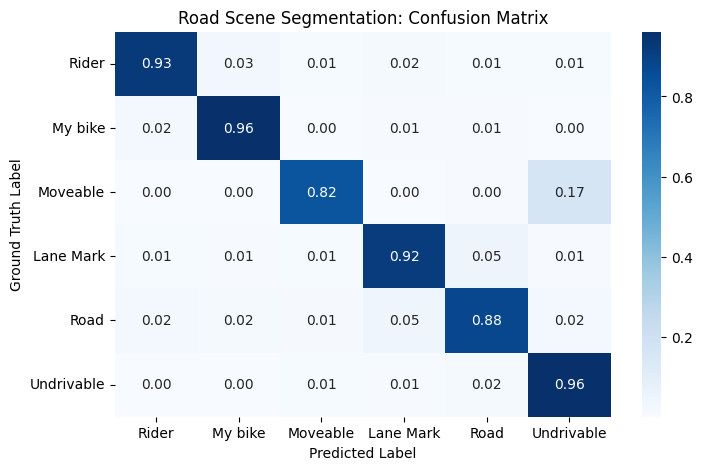


⚠️ Safety Risk Analysis: Best mBoU Model

=== [Safety-Critical Analysis] ===
--- 고위험 ---
1. 즉각적인 충돌 위험 - 'Undrivable' 영역의 1.84%가 'Road'로 오분류 됨.
2. 이동 물체 충돌 위험 - 'Moveable' 객체의 16.75%가 'Undrivable'로 오분류 됨.
3. 이동 물체 충돌 위험 - 'Moveable' 객체의 0.48%가 'Road'로 오분류 됨.
4. 시스템 오작동 유발 - 'Rider' 객체의 0.84%가 'Undrivable'로 오분류 됨.

--- 중위험 ---
5. 경로 계획 오류 - 'Road' 영역의 2.31%가 'Undrivable'로 오분류 됨.
6. 차선 유지 보조 오류 - 'Lane Mark' 영역의 5.26%가 'Road'로 오분류 됨.

--- 낮은-중간 위험 ---
7. 자기 인식 오류 - 'Rider' 객체의 2.70%가 'My bike'로 오분류 됨.


In [75]:
# Define the path to the saved checkpoints
CHECKPOINTS_DIR = "./checkpoints"

# Recreate the model architecture (it must be the same as during training)
# The configuration `CFG['model_name']`, `id2label`, `label2id`, `num_labels` are from previous cells.

# Model for Best mIoU
model_best_miou = SegformerForSemanticSegmentation.from_pretrained(
    CFG['model_name'],
    num_labels=len(id_to_idx),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
).to(CFG['device'])

# Load the state dictionary for the best mIoU model
miou_checkpoint_path = os.path.join(CHECKPOINTS_DIR, "segformer_best_miou.pth")
model_best_miou.load_state_dict(torch.load(miou_checkpoint_path, map_location=CFG['device']))
model_best_miou.eval()

# Model for Best mBoU
model_best_mbou = SegformerForSemanticSegmentation.from_pretrained(
    CFG['model_name'],
    num_labels=len(id_to_idx),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
).to(CFG['device'])

# Load the state dictionary for the best mBoU model
mbou_checkpoint_path = os.path.join(CHECKPOINTS_DIR, "segformer_best_mbou.pth")
model_best_mbou.load_state_dict(torch.load(mbou_checkpoint_path, map_location=CFG['device']))
model_best_mbou.eval()

# Call the profiling function for model_best_miou
profile_model(model_best_miou, CFG['img_size'], CFG['device'])

print("\n" + "="*50 + "\n") # Separator for clarity

# Call the profiling function for model_best_mbou
profile_model(model_best_mbou, CFG['img_size'], CFG['device'])

# Run safety evaluation for model_best_miou
run_safety_evaluation(
    model_best_miou,
    "Best mIoU Model",
    test_loader,
    CFG['device'],
    CFG_EVAL['num_classes'],
    id2label
)

print("\n" + "="*50 + "\n") # Separator for clarity

# Run safety evaluation for model_best_mbou
run_safety_evaluation(
    model_best_mbou,
    "Best mBoU Model",
    test_loader,
    CFG['device'],
    CFG_EVAL['num_classes'],
    id2label
)